## First, implement similarity metrics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [38]:
# converting to square

def flat_to_square(actual, ideal):
    sqrt_size = int(actual.shape[1] ** 0.5)
    first_layer_size = actual.shape[0]

    actual_structural = actual.reshape(first_layer_size, sqrt_size, sqrt_size)
    ideal_structural = ideal.reshape(first_layer_size, sqrt_size, sqrt_size)
    return actual_structural, ideal_structural

# MSE
def mse(actual, ideal):
    return np.mean((actual.flatten() - ideal.flatten()) ** 2)

# Cosine Similarity
def cos_sim(actual, ideal):
    actual_flat, ideal_flat = actual.flatten(), ideal.flatten()
    dot = np.dot(actual_flat, ideal_flat)
    return 0 if dot == 0 else dot / (np.linalg.norm(actual_flat) * np.linalg.norm(ideal_flat)) 

# peak signal to noise ratio
def psnr(actual, ideal):
    print('dont use psnr')
    assert False
    return skimage.metrics.peak_signal_noise_ratio(actual, ideal)

# Structural Similarity Index (SSIM)
# need to specify data_range for this method
def ssim(actual_structural, ideal_structural): 
    combined = np.concatenate((actual_structural.flatten(), ideal_structural.flatten()))
    data_range = np.max(combined) - np.min(combined)

    if data_range == 0: return 1

    temp = skimage.metrics.structural_similarity(actual_structural, ideal_structural, data_range=data_range, win_size=3)
    return temp

# Infinity norm
def inf_norm(actual, ideal):
    return np.abs(actual-ideal).max()
    #D = actual - ideal
    #return np.linalg.norm(D, ord=np.inf)

def compare_gradients(approx, ideal, metric_func):
    return metric_func(approx, ideal)

## Then, we implement gradient plotting

In [43]:
def plot_grad_dist(metrics, 
                   p_vals, 
                   get_grad_dist_func, 
                   model_weight_types, 
                   model_layer_names, 
                   dataset_name, 
                   plot_acc = False, 
                   fig_name_prefix = 'test'):

    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    if plot_acc:
        avg_acc_arr = np.zeros_like(p_vals)
        for i, p in enumerate(p_vals):
            avg_acc_arr[i] = np.mean(np.load(f'models/{dataset_name}/{p}/train/acc.npy'))

    for idx, metric_func in enumerate(metrics):
        for grad_loc in ['start', 'end']:

            grad_dists, grad_stds = get_grad_dist_func(metric_func, p_vals, model_weight_types, model_layer_names, dataset_name, grad_loc)
            #print(f'{grad_loc}_{metric_func.__name__}')
            #print(grad_dists)
            if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
                ax = axs[idx]
            else:
                ax = axs  # Use axs directly if there's only one metric
            
            
            if plot_acc:
                ax.plot(avg_acc_arr, grad_dists, label=f'{grad_loc}_{metric_func.__name__}')
                ax.fill_between(avg_acc_arr, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
            else:
                ax.plot(p_vals, grad_dists, label=f'{grad_loc}_{metric_func.__name__}')
                ax.fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        if plot_acc:
            ax.set_xlabel('accuracy')
        else:
            ax.set_xlabel('p values')
            ax.set_xscale('log')
        if metric_func.__name__ in ['mse', 'inf_norm']:
            ax.set_yscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()
    
    plt.tight_layout()
    if plot_acc: # plotting against accuracy
        img_name = f'similarity_metric_plots/{fig_name_prefix}_{dataset_name}_acc.png'
    else: # plotting against p_values
        img_name = f'similarity_metric_plots/{fig_name_prefix}_{dataset_name}_p.png'
    plt.savefig(img_name)
    plt.show()

In [28]:
def get_grad_dist(metric_func, 
                        p_vals, 
                        model_weight_types, 
                        model_layer_names,
                        exp_name, grad_loc):
    num_p = len(p_vals)
    num_tasks = 5
    num_runs = 10

    #model_weight_types = ['weight']
    #model_layer_names = ['grad_layers.0']
    num_grad_files = len(model_weight_types)*len(model_layer_names)

    data_tensor = np.zeros((num_p, num_runs, num_tasks, num_grad_files))
    for p_index, p in enumerate(p_vals):
        for run in range(num_runs):
            for task in range(num_tasks):
                grad_index = 0
                for model_layer_prefix in model_layer_names: # loop over model layer names
                    for weight_type in model_weight_types: # loop over types of weights
                        weight_name = f'{model_layer_prefix}.{weight_type}.npy'
                        p_grad_actual_arr = np.load(f'models/{exp_name}/{p}/run_{run}/ideal_grad_task_{task}/{grad_loc}_grad/{weight_name}')
                        p_grad_ideal_arr =  np.load(f'models/{exp_name}/1/train/task_{task}/{grad_loc}_grad/{weight_name}')

                        # print(f"max for run#{run}, task#{task} is: {np.max(p_grad_actual_arr)}")

                        data_tensor[p_index, run, task, grad_index] = compare_gradients(p_grad_actual_arr, p_grad_ideal_arr, metric_func)
                        grad_index += 1

    data = np.mean(data_tensor, axis = -1) # avg over grad files
    data = np.mean(data, axis = -1) # avg over tasks
    p_mean = np.mean(data, axis = -1) # avg over runs
    p_std = np.std(data, axis = -1)

    return p_mean, p_std

## Finally, apply pipeline on our results

MNIST

using all good metrics

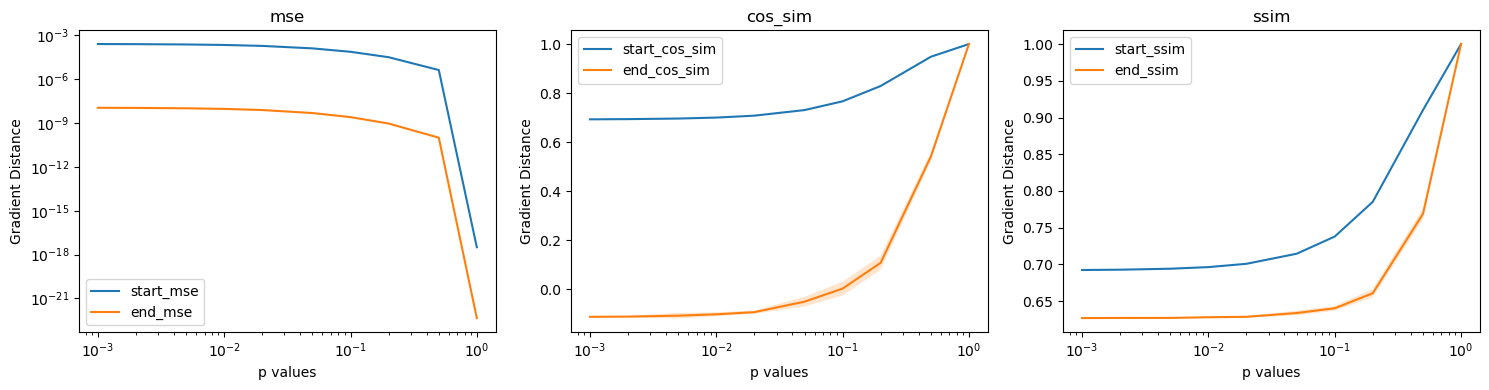

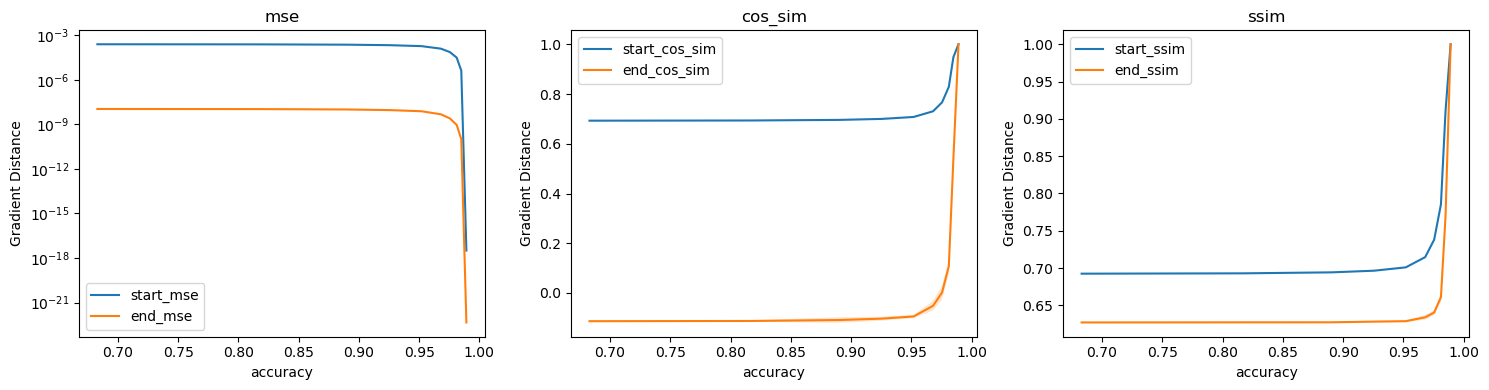

In [44]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight']
model_layer_names = ['grad_layers.0']
dataset_name = 'MNIST_split'
fig_name_prefix = 'all_metrics'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

CIFAR

all good metrics

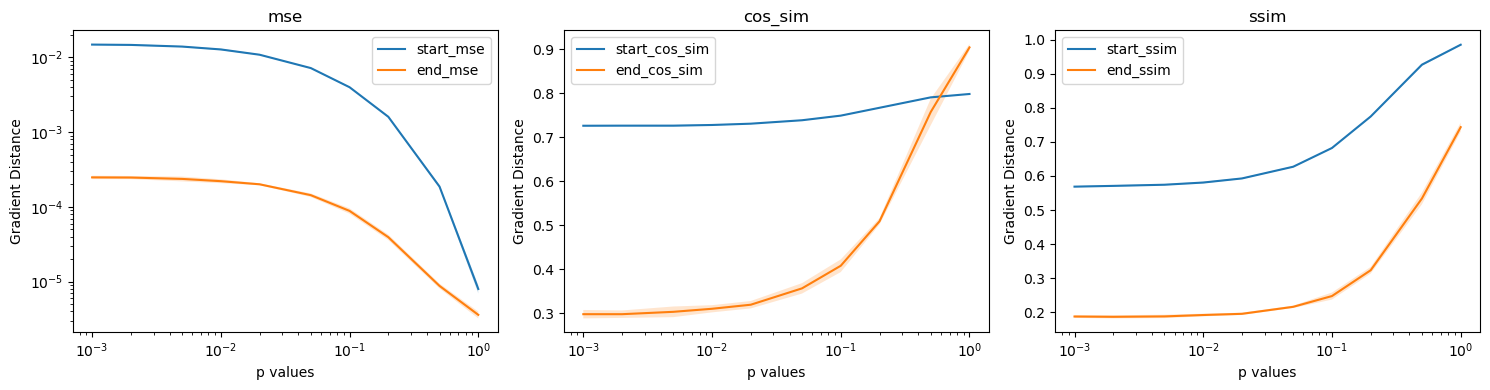

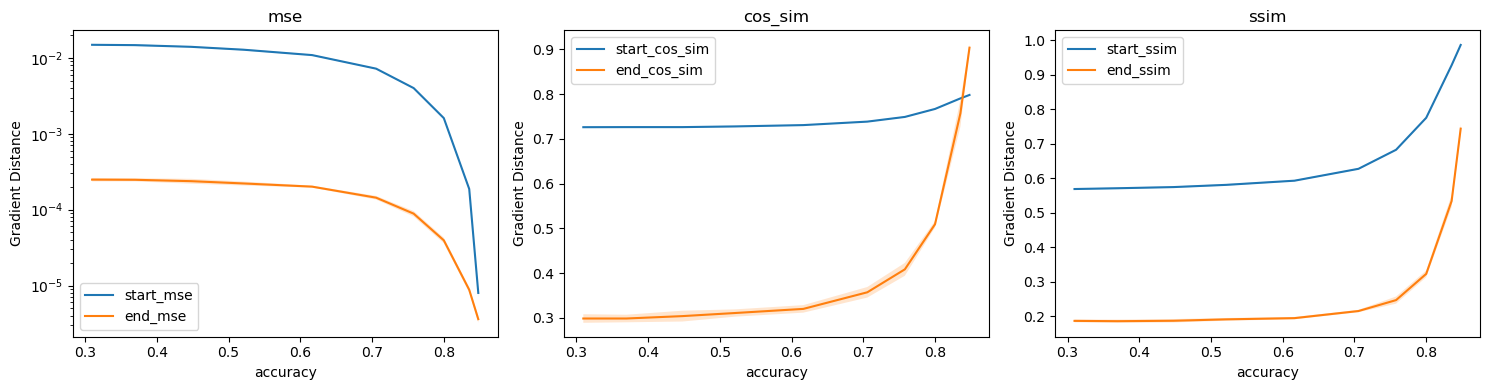

In [45]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight']
model_layer_names = ['grad_conv_block.0', 'grad_conv_block.2', 'grad_conv_block.6', 'grad_conv_block.8']
dataset_name = 'cifar10_split'
fig_name_prefix = 'all_metrics'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

MNIST

good metrics, no ssim, so done on all layers

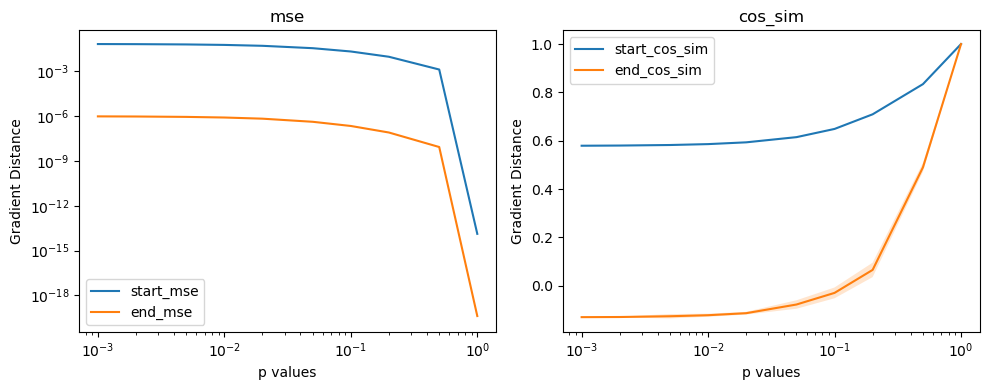

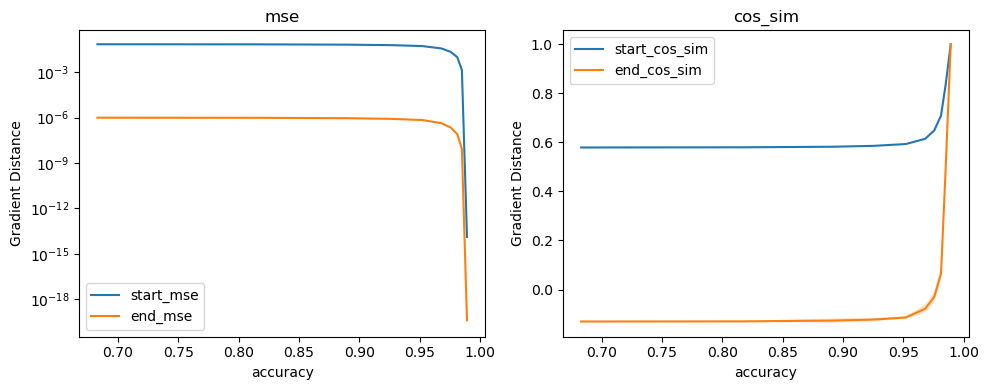

In [46]:
metrics_list = [mse, cos_sim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_layers.0', 'grad_output_layer']
dataset_name = 'MNIST_split'
fig_name_prefix = 'all_layers'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

CIFAR

good metrics, all layers

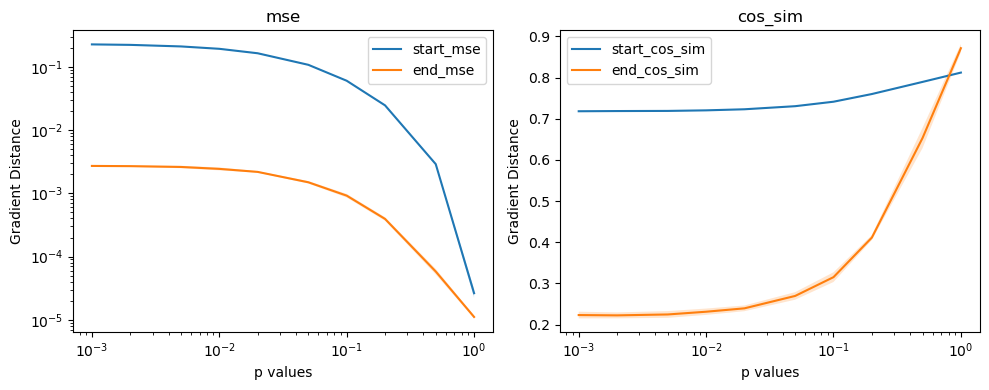

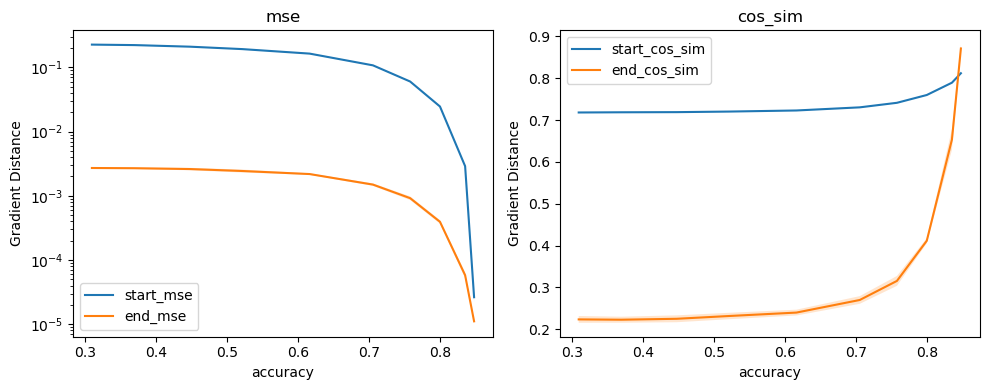

In [47]:
metrics_list = [mse, cos_sim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_conv_block.0', 'grad_conv_block.2', 'grad_conv_block.6', 'grad_conv_block.8',
                     'grad_linear_block.0', 'grad_out_block']
dataset_name = 'cifar10_split'
fig_name_prefix = 'all_layers'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

MNIST bad metrics

We will do this on all layers

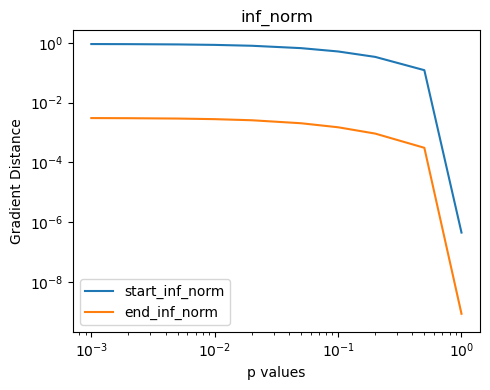

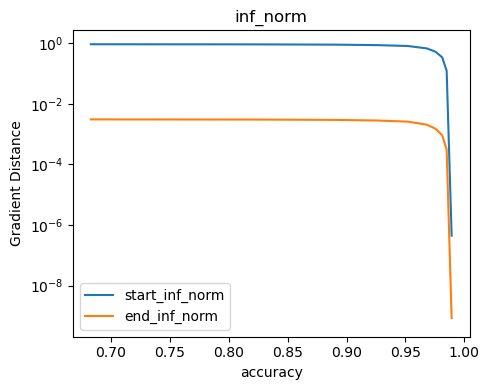

In [48]:
metrics_list = [inf_norm]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_layers.0', 'grad_output_layer']
dataset_name = 'MNIST_split'
fig_name_prefix = 'bad_metrics'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

CIFAR

bad metrics on all layers

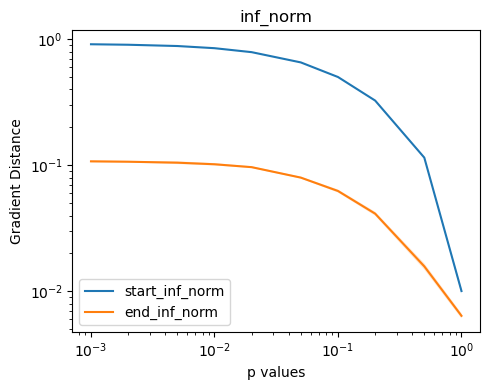

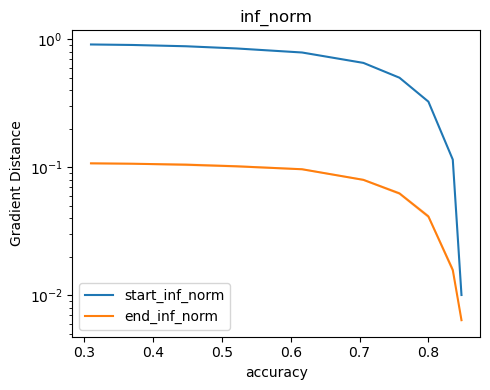

In [49]:
metrics_list = [inf_norm]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_conv_block.0', 'grad_conv_block.2', 'grad_conv_block.6', 'grad_conv_block.8',
                     'grad_linear_block.0', 'grad_out_block']
dataset_name = 'cifar10_split'
fig_name_prefix = 'bad_metrics'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)